In [47]:
import os, re, json
import numpy as np

from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u

import lsst.daf.persistence as dafPersist
import lsst.afw.geom as afwGeom
import lsst.geom as geom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
%matplotlib inline

from astropy.visualization import ZScaleInterval, ImageNormalize

import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [48]:
plt.rcParams['figure.figsize'] = (10, 10)
zscale = ZScaleInterval()
root_dir = '/pscratch/sd/y/yaswante/MyQuota/'

## Making a Cutout Image

The DM butler's `get` method enables postage stamp making, via a bounding box keyword argument. The functions below show how to make this bounding box, and apply it.

In [ ]:
# image_data = np.load(file_name)[0, :, :]

# get ann file
# get filename from ann file
# load image data from file?
# choose a single pixel corner (0, 0)
# convert that pixel coords to WCS coords using the truth's WCS info
# once we have the RA and DEC, then send that ra and dec into get_cutout_images
# for multiple, we repeat the same process except now we append the ra and dec we get from coords into an array
# and then send those two ras and decs array to get_cutout_images

In [100]:
def get_ras_decs(ann_file):
    ras = []
    decs = []
    filenames = []
    with open(ann_file, 'r') as f:
        data = json.load(f)
    for d in data:
        file_name = d['file_name']
        truth_patch_dir = (re.search(r'truth/(.+)/', file_name)).group(1)
        truth_info_filename = f'{root_dir}truth/{truth_patch_dir}/{truth_patch_dir}_info.json'
        with open(truth_info_filename, 'r') as f:
            all_truth_info = json.load(f)
        for truth_img in all_truth_info:
            if truth_img['file_name'] == file_name:
                wcs = WCS(truth_img['wcs'])
                coords_tl = wcs.pixel_to_world(0, 0) # getting RA and DEC of top-left corner of cutout
                coords_br = wcs.pixel_to_world(511, 511) # getting RA and DEC of bottom-right corner of cutout
                ras.append((coords_tl.ra.value, coords_br.ra.value))
                decs.append((coords_tl.dec.value, coords_br.dec.value))
                filenames.append(file_name)
                break

    return ras, decs, np.asarray(filenames)

In [101]:
ras, decs, filenames = get_ras_decs('/pscratch/sd/y/yaswante/MyQuota/annotations/dc2_50.93_-42.0.json')

In [102]:
def get_cutout_images_nb(butler, ras, decs, band, datasetType='deepCoadd', 
                     skymap=None, cutoutSideLength=512, **kwargs):
    cutout_imgs = []
    # radecs = []
    if skymap is None:
        skymap = butler.get(f"{datasetType}_skyMap")
    for ra, dec in zip(ras, decs):
        # Look up the tract, patch for both corners' RA & Dec
        radec = geom.SpherePoint(ra[0], dec[0], geom.degrees)
        tractInfo = skymap.findTract(radec)
        xy1 = geom.PointI(tractInfo.getWcs().skyToPixel(radec))        
        
        radec2 = geom.SpherePoint(ra[1], dec[1], geom.degrees)
        tractInfo2 = skymap.findTract(radec2)
        xy2 = geom.PointI(tractInfo2.getWcs().skyToPixel(radec2))
        
        # creating the bbox for getting postage stamp        
        bbox = geom.BoxI(geom.PointI(xy1),geom.PointI(xy2))
        # cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

        patchInfo = tractInfo.findPatch(radec)

        patch_xy = patchInfo.getIndex()
        coaddId = {'tract': tractInfo.getId(), 'patch': f"{patch_xy[0]},{patch_xy[1]}", 'filter': band}
        cutout_image = butler.get(datasetType+'_sub', bbox=bbox, immediate=True, dataId=coaddId)
        # print("After getting cutout_image: ", ra)
        cutout_imgs.append(cutout_image)
        # print(radec, "\n", radec2)
        # radecs.append(radec)
        break # to only get one LSST image

    # return cutout_imgs
    return cutout_imgs

def get_cutout_images_v2(butler, ras, decs, filename, band, datasetType='deepCoadd', 
                     skymap=None, cutoutSideLength=512, **kwargs):
    cutout_imgs = []
    # radecs = []
    if skymap is None:
        skymap = butler.get(f"{datasetType}_skyMap")
    for ra, dec in zip(ras, decs):
        # Look up the tract, patch for both corners' RA & Dec
        radec = geom.SpherePoint(ra[0], dec[0], geom.degrees)
        tractInfo = skymap.findTract(radec)
        xy1 = geom.PointI(tractInfo.getWcs().skyToPixel(radec))        
        
        radec2 = geom.SpherePoint(ra[1], dec[1], geom.degrees)
        tractInfo2 = skymap.findTract(radec2)
        xy2 = geom.PointI(tractInfo2.getWcs().skyToPixel(radec2))
        
        # creating the bbox for getting postage stamp        
        bbox = geom.BoxI(geom.PointI(xy1),geom.PointI(xy2))
        # cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

        patchInfo = tractInfo.findPatch(radec)

        patch_xy = patchInfo.getIndex()
        coaddId = {'tract': tractInfo.getId(), 'patch': f"{patch_xy[0]},{patch_xy[1]}", 'filter': band}
        try:
            cutout_image = butler.get(datasetType+'_sub', bbox=bbox, immediate=True, dataId=coaddId)
            yield
        except Exception as e:
            print(e)
            print(bbox)
            print("RA and DEC of failed fetch: ", ra, dec)
            print(filename)
            continue
        # print("After getting cutout_image: ", ra)
        # cutout_imgs.append(cutout_image)
        # print(radec, "\n", radec2)
        # radecs.append(radec)
        # break # to only get one LSST image

    # return cutout_imgs
    return cutout_imgs

def get_cutout_images_single(butler, ras, decs, band, datasetType='deepCoadd', 
                     skymap=None, cutoutSideLength=512, **kwargs):
    cutout_imgs = []
    # radecs = []
    if skymap is None:
        skymap = butler.get(f"{datasetType}_skyMap")
    for ra, dec in zip(ras, decs):
        # Look up the tract, patch for both corners' RA & Dec
        radec = geom.SpherePoint(ra[0], dec[0], geom.degrees)
        tractInfo = skymap.findTract(radec)
        xy1 = geom.PointI(tractInfo.getWcs().skyToPixel(radec))        
        
        radec2 = geom.SpherePoint(ra[1], dec[1], geom.degrees)
        tractInfo2 = skymap.findTract(radec2)
        xy2 = geom.PointI(tractInfo2.getWcs().skyToPixel(radec2))
        
        # creating the bbox for getting postage stamp        
        bbox = geom.BoxI(geom.PointI(xy1),geom.PointI(xy2))
        # cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

        patchInfo = tractInfo.findPatch(radec)

        patch_xy = patchInfo.getIndex()
        coaddId = {'tract': tractInfo.getId(), 'patch': f"{patch_xy[0]},{patch_xy[1]}", 'filter': band}
        cutout_image = butler.get(datasetType+'_sub', bbox=bbox, immediate=True, dataId=coaddId)
        # print("After getting cutout_image: ", ra)
        cutout_imgs.append(cutout_image)
        # print(radec, "\n", radec2)
        # radecs.append(radec)
        # break # to only get one LSST image

    # return cutout_imgs
    return cutout_imgs

In [54]:
repo = '/global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/rerun/run2.2i-dr6-v2'
butler = dafPersist.Butler(repo)

In [103]:
import time
start_time = time.time()
# using yield
# for ra, dec, filename in zip(ras, decs, filenames):
#     for lsst_img in get_cutout_images_v2(butler, [ra], [dec], filename, band='u'):
#         pass

# single
# lsst_imgs_u = get_cutout_images_single(butler, [ras[232]], [decs[232]], band='u')

# for demo
lsst_imgs_u = get_cutout_images_nb(butler, ras, decs, band='u')
lsst_imgs_g = get_cutout_images_nb(butler, ras, decs, band='g')
lsst_imgs_r = get_cutout_images_nb(butler, ras, decs, band='r')
lsst_imgs_i = get_cutout_images_nb(butler, ras, decs, band='i')
lsst_imgs_z = get_cutout_images_nb(butler, ras, decs, band='z')
lsst_imgs_y = get_cutout_images_nb(butler, ras, decs, band='y')
end_time = time.time()
print(end_time - start_time, " seconds")

8.696309804916382  seconds


In [104]:
len(lsst_imgs_i)

1

6 s for all 6 bands to get the image so 1 img / 6 seconds
<!-- for 280 images, we have 280 * 6 = 1680 s = 28 mins for all 6 bands -->

In [105]:
print(lsst_imgs_u[0].image.array.shape)
print(lsst_imgs_g[0].image.array.shape)
print(lsst_imgs_r[0].image.array.shape)
print(lsst_imgs_i[0].image.array.shape)
print(lsst_imgs_z[0].image.array.shape)
print(lsst_imgs_y[0].image.array.shape)
# grabbing just the first radec lsst img for demonstration
all_img_bands = [lsst_imgs_u[0].image.array, lsst_imgs_g[0].image.array, lsst_imgs_r[0].image.array, 
                 lsst_imgs_i[0].image.array, lsst_imgs_z[0].image.array, lsst_imgs_y[0].image.array]

(147, 150)
(147, 150)
(147, 150)
(147, 150)
(147, 150)
(147, 150)


In [106]:
def plot_lsst_img(cutout_image):
    # plt.imshow(cutout_image, norm=colors.LogNorm(), cmap='inferno', origin='lower')
    vmin, vmax = zscale.get_limits(cutout_image)
    plt.imshow(cutout_image, vmin=vmin, vmax=vmax, cmap='binary_r', origin='lower')
    # plt.xlim(0, 150)
    # plt.ylim(147, 0)
    plt.colorbar()
    # plt.scatter(xy.getX() - cutout_image.getX0(), xy.getY() - cutout_image.getY0(),
    #             color='none', edgecolor='red', marker='o', s=200)
    # return vmin, vmax

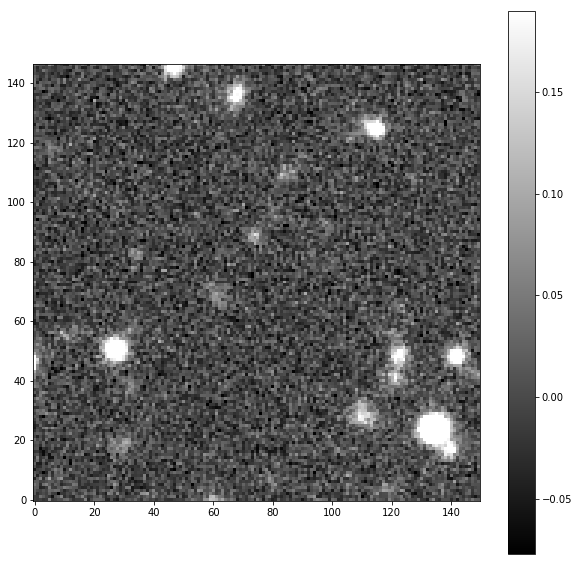

In [107]:
# 2-band
plot_lsst_img(all_img_bands[2])

In [108]:
def plot_lsst_imgs(all_img_bands):
    titles = ['u', 'g', 'r', 'i', 'z', 'y']
    fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)
    for ax, title, img in zip(axes.flatten(), titles, all_img_bands):
        ax.set_title(f'LSST - {title}')
        vmin, vmax = zscale.get_limits(img)
        ax.imshow(img, vmin=vmin, vmax=vmax, cmap='binary_r', origin='lower')
    plt.tight_layout()

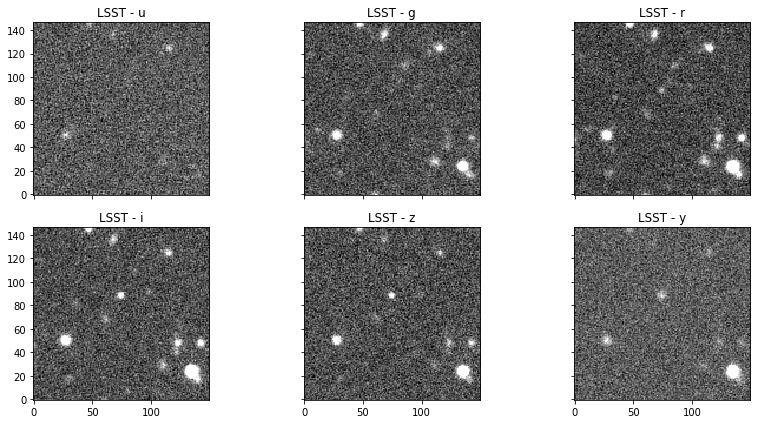

In [109]:
plot_lsst_imgs(all_img_bands)

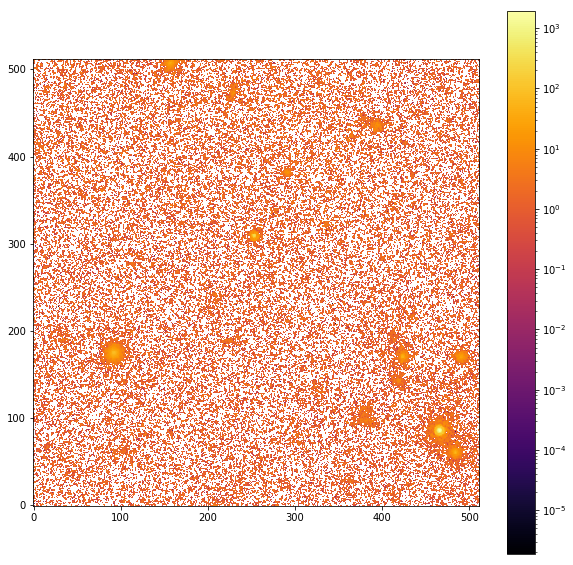

In [110]:
def plt_roman_img(roman_img):
    vmin, vmax = zscale.get_limits(roman_img)
    plt.imshow(roman_img, norm=colors.LogNorm(), cmap='inferno', origin='lower')
    # plt.imshow(roman_img, vmin=vmin, vmax=vmax, cmap='binary_r', origin='lower')
    plt.colorbar()
    # plt.scatter(0, 511,
    #             color='none', edgecolor='green', marker='o', s=20)
    # plt.xlim(500, roman_img.shape[1] + 10)
    # plt.ylim(514, 510)

roman_img = np.load(root_dir + 'truth/dc2_50.93_-42.0/full_c2_50.93_-42.0.npy')[0, :, :]
roman_dims = roman_img.shape
plt_roman_img(roman_img)

# Making LSST Image the Same Shape as Roman

In [111]:
def plot_roman_lsst_img(lsst_img, roman_img, resize_type, linear_map=False, band='r', small_range=False, fig_size=(12,6)):
    fig, axes = plt.subplots(1, 2, figsize=fig_size)
    ax1, ax2 = axes
    if linear_map is True:
        vmin, vmax = zscale.get_limits(lsst_img)
        ax1.imshow(lsst_img, vmin=vmin, vmax=vmax, cmap='binary_r', origin='lower')
    elif band is 'g' and small_range is True:
        vmin, vmax = np.min(lsst_img), np.max(lsst_img)
        ax1.imshow(lsst_img, norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03, vmin=vmin, vmax=vmax), cmap='inferno', origin='lower')
    else:
        ax1.imshow(lsst_img, norm=colors.LogNorm(), cmap='inferno', origin='lower')
    ax1.set_title(f'LSST - {band} ({resize_type})')
    ax2.imshow(roman_img, norm=colors.LogNorm(), cmap='inferno', origin='lower')
    ax2.set_title('Roman')

In [112]:
def plot_roman_lsst_imgs(all_img_bands, roman_img, resize_type, linear_map=False, small_range=False):
    titles = ['u', 'g', 'r', 'i', 'z', 'y']
    fig, axes = plt.subplots(3, 3, figsize=(15, 10), gridspec_kw={'height_ratios': [1, 1, 1]}, sharex=True, sharey=True)
    ax_roman = plt.subplot2grid((3, 3), (0, 0), colspan=3, fig=fig)
    ax_roman.imshow(roman_img, norm=colors.LogNorm(), cmap='inferno', origin='lower')
    ax_roman.set_xticks(np.linspace(0, 500, num=6))
    ax_roman.set_title('Roman')
    for ax, title, img in zip(axes[1:].flatten(), titles, all_img_bands):
        ax.set_title(f'LSST - {title}')
        if linear_map is True:
            vmin, vmax = zscale.get_limits(img)
            ax.imshow(img, vmin=vmin, vmax=vmax, cmap='binary_r', origin='lower')
        elif title is 'g' and small_range is True:
            vmin, vmax = np.min(img), np.max(img)
            ax.imshow(img, norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03, vmin=vmin, vmax=vmax), cmap='inferno', origin='lower')
        else:
            ax.imshow(img, norm=colors.LogNorm(), cmap='inferno', origin='lower')
    fig.suptitle(f'LSST {resize_type}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)

### Trying simple np.resize

In [33]:
resized_imgs = []
for img in all_img_bands:
    resized_imgs.append(np.resize(img, roman_img.shape))

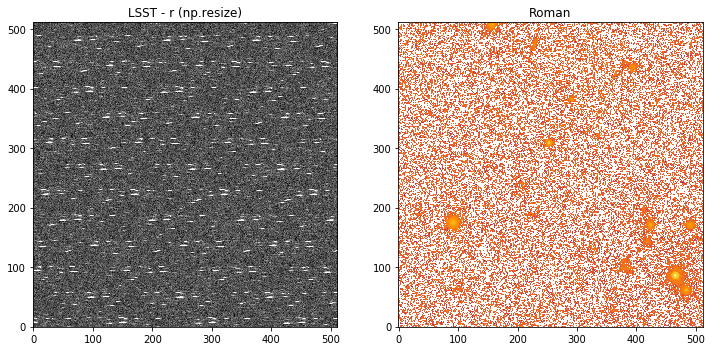

In [34]:
plot_roman_lsst_img(resized_imgs[2], roman_img, 'np.resize', linear_map=True)

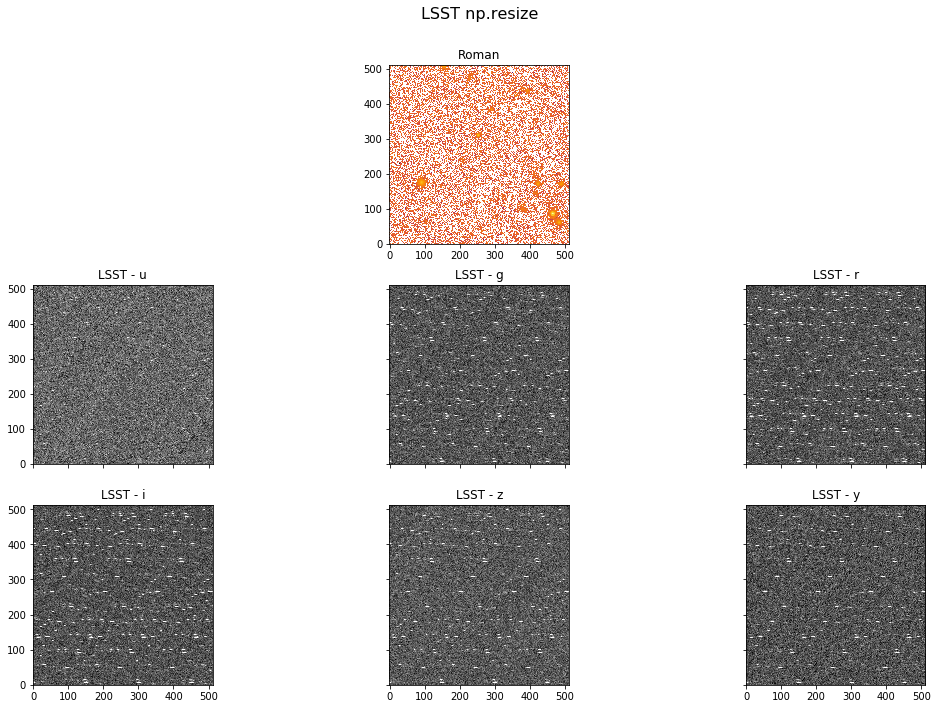

In [35]:
plot_roman_lsst_imgs(resized_imgs, roman_img, resize_type='np.resize', linear_map=True)

### Using the padding

In [36]:
# finding the padding (saame for each band since they all have the same shape)
py = (roman_dims[0] - all_img_bands[0].shape[0]) // 2  # height
px = (roman_dims[1] - all_img_bands[0].shape[1]) // 2  # width

# handling odd dims
py_extra = (roman_dims[0] - all_img_bands[0].shape[0]) % 2
px_extra = (roman_dims[1] - all_img_bands[0].shape[1]) % 2

padded_lsst_imgs = []
for img in all_img_bands:
    padded_img = np.pad(img, ((py, py + py_extra), 
                              (px, px + px_extra)),
                        mode='constant', constant_values=0)  # padding with zeroes
    padded_lsst_imgs.append(padded_img)

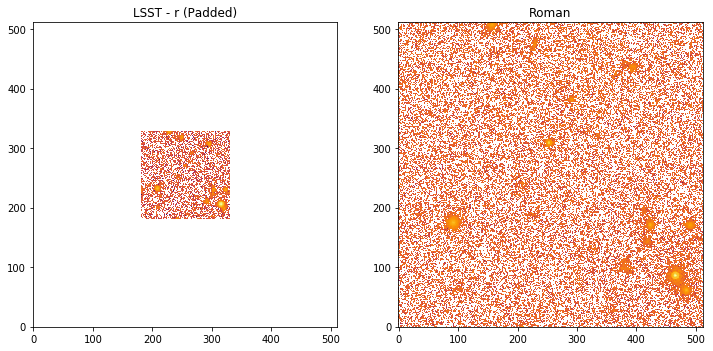

In [37]:
# r - band
plot_roman_lsst_img(padded_lsst_imgs[2], roman_img, resize_type='Padded')

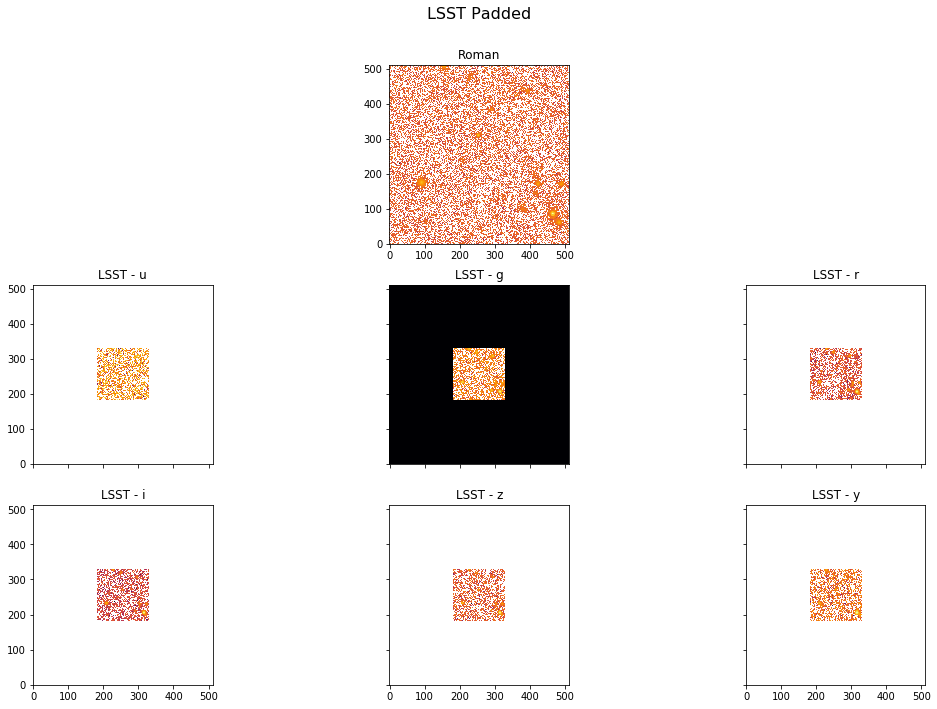

In [38]:
plot_roman_lsst_imgs(padded_lsst_imgs, roman_img, resize_type='Padded')

In [39]:
# for g band, much smaller dynamic range of pixel values AKA a narrow range of values close to zero meaning
# lognorm makes low values (like 0) look a lot darker compared to the rest of the image data bc log of vals close to zero 
# drops off sharply towards -inf making pic look black
all_img_bands[1].min(), all_img_bands[1].max()

(-0.1022714, 1.7700436)

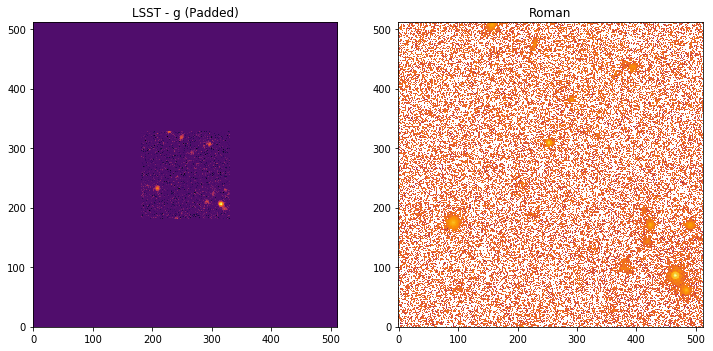

In [40]:
# if needed, we can just use a diff normalization with diff calculated vmin and vmax (SymLogNorm)
plot_roman_lsst_img(padded_lsst_imgs[1], roman_img, resize_type='Padded', band='g', small_range=True)

### Upsampling LSST with Interpolation

In [20]:
from scipy.ndimage import zoom 
# zoom - spline interpolation of a given order (https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.zoom.html)
# could also use cv2 but not available in conda env (cv2.resize(lsst_img, (roman_dims[1], roman_dims[0]), interpolation=cv2.INTER_CUBIC))

# zoom factors
zoom_y = roman_dims[0] / all_img_bands[0].shape[0]
zoom_x = roman_dims[1] / all_img_bands[0].shape[1]

# cubic interpolation
upsampled_lsst_imgs = [zoom(img, (zoom_y, zoom_x), order=3) for img in all_img_bands]

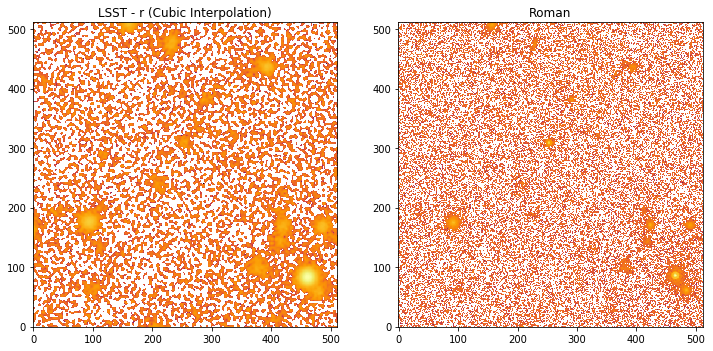

In [21]:
plot_roman_lsst_img(upsampled_lsst_imgs[2], roman_img, resize_type='Cubic Interpolation')

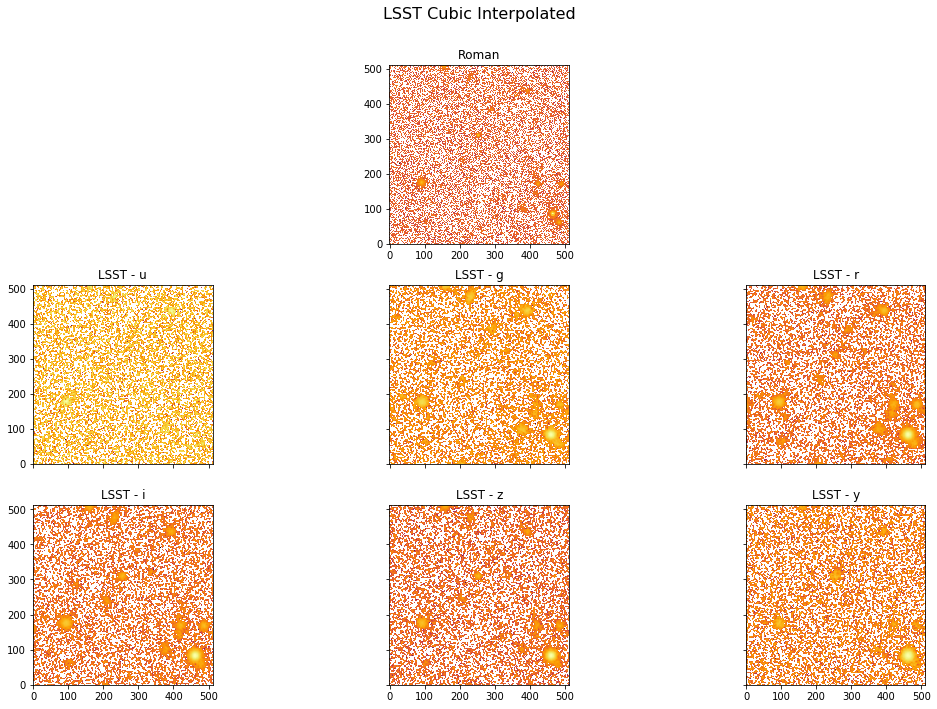

In [22]:
plot_roman_lsst_imgs(upsampled_lsst_imgs, roman_img, resize_type='Cubic Interpolated')

In [119]:
# lanczos (spline interpolation)
upsampled_lsst_imgs_lz4 = [zoom(img, (zoom_y, zoom_x), order=4) for img in all_img_bands]
upsampled_lsst_imgs_lz5 = [zoom(img, (zoom_y, zoom_x), order=5) for img in all_img_bands]

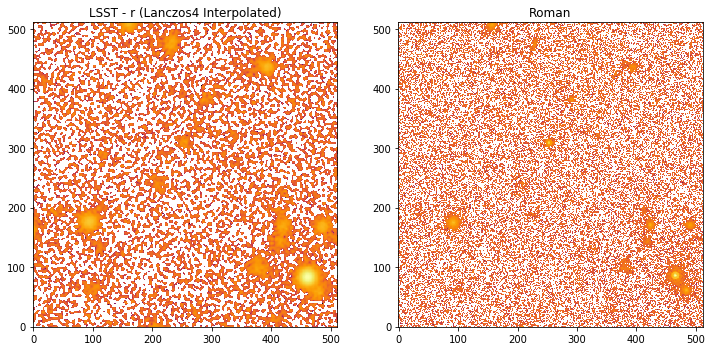

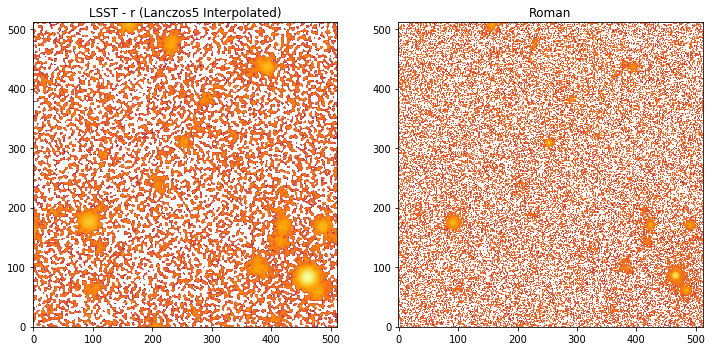

In [121]:
# plt.imshow(roman_img, norm=colors.LogNorm(), cmap='binary_r', origin='lower')
# # plt.imshow(upsampled_lsst_imgs_lz[2], alpha=0.3, norm=colors.LogNorm(), cmap='inferno', origin='lower')
plot_roman_lsst_img(upsampled_lsst_imgs_lz4[2], roman_img, resize_type='Lanczos4 Interpolated')
plot_roman_lsst_img(upsampled_lsst_imgs_lz5[2], roman_img, resize_type='Lanczos5 Interpolated')

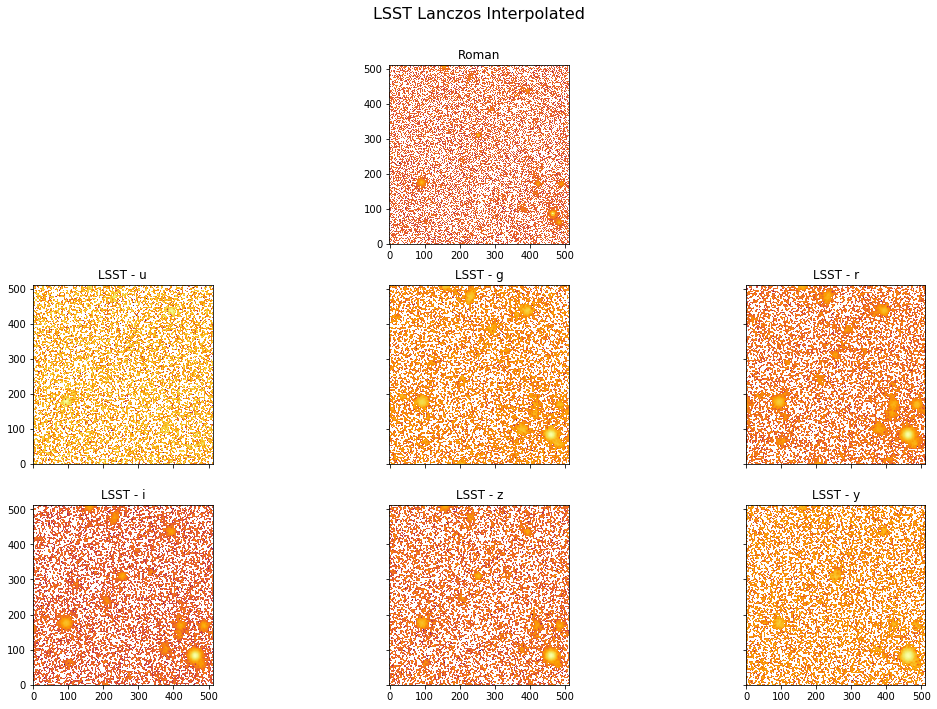

In [53]:
plot_roman_lsst_imgs(upsampled_lsst_imgs_lz, roman_img, resize_type='Lanczos Interpolated')

In [66]:
def estimate_disk_size(shape, dtype):
    num_elements = np.prod(shape) 
    # size of data type (B)
    type_size = np.dtype(dtype).itemsize
    return num_elements * type_size

size_cubic = estimate_disk_size(upsampled_lsst_imgs[2].shape, 'float32')
size_lanczos = estimate_disk_size(upsampled_lsst_imgs_qi[2].shape, 'float32')
print(f"Estimated size for cubic on disk is: {size_cubic} bytes")
print(f"Estimated size for lanczos on disk is: {size_lanczos} bytes")

Estimated size for cubic on disk is: 1048576 bytes
Estimated size for lanczos on disk is: 1048576 bytes


# Adding LSST Image Data to Existing Roman Data

In [28]:
for file in filenames:
    print("Old File: ", file)
    curr_rimg_filename = file.replace('./roman_data/', root_dir)
    # roman_im = np.load(root_dir + 'truth/dc2_50.93_-42.0/full_c2_50.93_-42.0.npy')
    new_filename = file.replace('truth', 'truth-combined')
    # adding new_filename to annotations
    cutout_filename = (re.search(r'roman_data/(.+)', new_filename)).group(1) # removes 
    # print(cutout_filename)
    full_cutout_filename = f'{root_dir}{cutout_filename}'
    print("Grabbing Image at :", curr_rimg_filename)
    roman_im = np.load(curr_rimg_filename)
    print("Roman: ", roman_im.shape)
    # print(roman_im[0, :, :])
    print("LSST: ", np.asarray(upsampled_lsst_imgs_lz).shape)
    # print(np.asarray(upsampled_lsst_imgs_lz)[-1, :, :])
    combined_data = np.concatenate((roman_im, upsampled_lsst_imgs_lz), axis=0)
    # print(combined_data.shape)
    # print(combined_data[5, :, :])
    print(f"For NERSC {root_dir}: {full_cutout_filename}")
    np.save(f'./test.npy', combined_data)
    break

Old File:  ./roman_data/truth/dc2_50.93_-42.0/full_c2_50.93_-42.0.npy
Grabbing Image at : /pscratch/sd/y/yaswante/MyQuota/truth/dc2_50.93_-42.0/full_c2_50.93_-42.0.npy
Roman:  (4, 512, 512)
LSST:  (6, 512, 512)
For NERSC /pscratch/sd/y/yaswante/MyQuota/: /pscratch/sd/y/yaswante/MyQuota/truth-combined/dc2_50.93_-42.0/full_c2_50.93_-42.0.npy


In [106]:
def change_filename(old_ann_filename):
    with open(old_ann_filename, 'r') as f:
        data = json.load(f)
    updated_data = []

    for d in data:
        file_name = d['file_name']
        new_filename = file_name.replace('truth', 'truth-combined')
        d_new = d.copy()
        d_new['file_name'] = new_filename
        updated_data.append(d_new)

    # old_ann_filename = '/pscratch/sd/y/yaswante/MyQuota/annotations/train_roman.json'
    new_ann_filename = old_ann_filename.replace('annotations', 'anns-rom-lsst')
    with open(new_ann_filename, 'w') as f:
        json.dump(updated_data, f)
    # print(old_ann_filename)
    # print(new_ann_filename)

/pscratch/sd/y/yaswante/MyQuota/annotations/train_roman.json
/pscratch/sd/y/yaswante/MyQuota/anns-rom-lsst/train_roman.json


### Testing that image has been correctly created from script

(10, 512, 512)


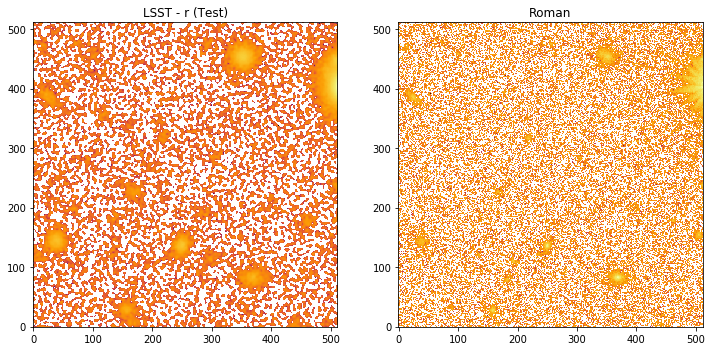

In [116]:
my_file = root_dir + 'truth-combined/dc2_53.25_-41.8/full_c56_53.25_-41.8.npy'
# my_file = root_dir + "truth-combined/dc2_52.93_-40.8/full_c253_52.93_-40.8.npy"
test = np.load(my_file)
print(test.shape)
test_roman = test[0, :, :]
test_lsst_r = test[6, :, :]
plot_roman_lsst_img(test_lsst_r, test_roman, 'Test', fig_size=(12,10))
# test_lsst_u = test[4, :, :]
# plot_roman_lsst_img(test_lsst_u, test_roman, 'Test', band='u', linear_map=True, fig_size=(12,10))
# print(f"Combined data has been saved to {full_cutout_filename}")

# Misc/Old Code

In [ ]:
def cutout_coadd_ra_dec(butler, ra, dec, filter='r', datasetType='deepCoadd', **kwargs):
    """
    Produce a cutout from coadd from the given butler at the given RA, Dec in decimal degrees.
    
    Notes
    -----
    Trivial wrapper around 'cutout_coadd_spherepoint'
    
    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, degrees
    dec: float
        Declination of the center of the cutout, degrees
    filter: string
        Filter of the image to load
        
    Returns
    -------
    MaskedImage
    """
    radec = afwGeom.SpherePoint(ra, dec, afwGeom.degrees)
    return cutout_coadd_spherepoint(butler, radec, filter=filter, datasetType=datasetType)


# def cutout_coadd_spherepoint(butler, radec, filter='r', datasetType='deepCoadd',
#                                   skymap=None, cutoutSideLength=51, **kwargs):
#     """
#     Produce a cutout from a coadd at the given afw SpherePoint radec position.
    
#     Parameters
#     ----------
#     butler: lsst.daf.persistence.Butler
#         Servant providing access to a data repository
#     radec: lsst.afw.geom.SpherePoint 
#         Coordinates of the center of the cutout.
#     filter: string 
#         Filter of the image to load
#     datasetType: string ['deepCoadd']  
#         Which type of coadd to load.  Doesn't support 'calexp'
#     skymap: lsst.afw.skyMap.SkyMap [optional] 
#         Pass in to avoid the Butler read.  Useful if you have lots of them.
#     cutoutSideLength: float [optional] 
#         Side of the cutout region in pixels.
    
#     Returns
#     -------
#     MaskedImage
#     """
#     cutoutSize = afwGeom.ExtentI(cutoutSideLength, cutoutSideLength)

#     if skymap is None:
#         skymap = butler.get("%s_skyMap" % datasetType)
    


    
#     cutout_image = butler.get(datasetType+'_sub', bbox=bbox, immediate=True, dataId=coaddId)
    
#     return cutout_image



In [109]:
dirt = '/pscratch/sd/y/yaswante/MyQuota/'
annotation_files = [dirt + 'annotations/train_roman.json', dirt + 'annotations/val_roman.json']
annotation_files

['/pscratch/sd/y/yaswante/MyQuota/annotations/train_roman.json',
 '/pscratch/sd/y/yaswante/MyQuota/annotations/val_roman.json']